# Investigating Discrepancies in Amount of Frames Extracted

In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import numpy as np

# from data_preprocessing import get_video_frames

In [5]:
#load video clip info dataframe
workspace_path = '/mount/data'
downloads_df = pd.read_csv(workspace_path + '/downloaded_videos.csv')
downloads_df.head()

,video_id,url,title,license,relevant,renamed_title,clip_start,clip_end,duration,frames_collected_opencv,frames_reported_opencv,frames_reported_decord
0,67OIlq2oMt0,https://youtu.be/67OIlq2oMt0,Hawaiian Islands Humpback Whale National Marin...,creativeCommon,True,video_0000.mp4,10,25,266.0,361.0,473.0,473.0
1,EUcMuUBMYJc,https://youtu.be/EUcMuUBMYJc,Tagging expedition: revealing the delicate nur...,creativeCommon,True,video_0001.mp4,44,59,269.0,360.0,441.0,441.0
2,dpSuygz7ZmA,https://youtu.be/dpSuygz7ZmA,Your Earth Is Blue: Disentangling a Humpback W...,creativeCommon,True,video_0002.mp4,5,20,102.0,361.0,398.0,398.0
3,jfPzlFLEuKk,https://youtu.be/jfPzlFLEuKk,"Humpback Whale || Description, Characteristics...",creativeCommon,True,video_0003.mp4,160,175,238.0,450.0,456.0,456.0
4,xGasapMoy4I,https://youtu.be/xGasapMoy4I,Your Earth Is Blue: Humpback Whales,creativeCommon,True,video_0004.mp4,0,15,83.0,451.0,451.0,451.0


In [10]:
downloads_df.shape

(364, 12)

# Checking frames downloads

In [11]:
import glob

count = 0 
for file in glob.glob(workspace_path + '/frames/clip*.jpg'):
    count += 1
    
expected_count = 364 * 461
print(f'There are a total of {count} .jpg files in our workspace frames directory')
print(f'The expected number of .jpg files in our workspace frames directory is {expected_count}')

There are a total of 167804 .jpg files in our workspace frames directory
The expected number of .jpg files in our workspace frames directory is 167804


We successfully downloaded all .jpg frames from our videos into the frames directory in our workspace!! Note: if we try opening up the directory, it won't open (probably bc of the sheer volume of 224x224 .jpg frames)

# Clean up frame directory (testing)

In [6]:
#remove frames from test frame directory
import os
import glob

# files = glob.glob('/workspace/youtube-humpback-whale-classifier/classification/frames/clip_0000_frame*.jpg')

#DELETING FROM WORKSPACE
files = glob.glob(workspace_path + '/frames/clip*.jpg')

for f in files:
    os.remove(f)

# Save frames as .jpg files in workspace with frame count limit 

`max_frames = 461`

More about Decord: 

- https://towardsdatascience.com/lightning-fast-video-reading-in-python-c1438771c4e6 

- https://github.com/dmlc/decord

- https://medium.com/@haydenfaulkner/extracting-frames-fast-from-a-video-using-opencv-and-python-73b9b7dc9661

In [160]:
downloads_df.head(3)

,video_id,url,title,license,relevant,renamed_title,clip_start,clip_end,duration,frames_collected_opencv,frames_reported_opencv,frames_reported_decord
0,67OIlq2oMt0,https://youtu.be/67OIlq2oMt0,Hawaiian Islands Humpback Whale National Marin...,creativeCommon,True,video_0000.mp4,10,25,266.0,361.0,473.0,473.0
1,EUcMuUBMYJc,https://youtu.be/EUcMuUBMYJc,Tagging expedition: revealing the delicate nur...,creativeCommon,True,video_0001.mp4,44,59,269.0,360.0,441.0,441.0
2,dpSuygz7ZmA,https://youtu.be/dpSuygz7ZmA,Your Earth Is Blue: Disentangling a Humpback W...,creativeCommon,True,video_0002.mp4,5,20,102.0,361.0,398.0,398.0


In [133]:
#trying out getting video frames for one video
actual, reported = get_video_frames('video_clip_0002.mp4', max_frames=461, context=cpu(0), resize=(224, 224))

In [4]:
#getting video frames for multiple videos
for i, row in downloads_df.iterrows(): 
    clip = row['renamed_title'].replace('_', '_clip_')
    
    #extract and save frames as .jpg files in frame folder 
    actual, reported = get_video_frames(clip, max_frames=461, context=cpu(0), resize=(224, 224))
    
    #store frame count metrics for bookkeeping
    downloads_df.at[i, ('frames_collected_decord')] = actual
    downloads_df.at[i, ('frames_reported_decord')] = reported

print('Done saving frames.')

363
Done checking frames
461 461


# Testing Out Multinode Processing for Downloading Frames

Source: https://medium.com/@haydenfaulkner/extracting-frames-fast-from-a-video-using-opencv-and-python-73b9b7dc9661

In [159]:
import sys, os
from multiprocessing import Pool, cpu_count
from functools import partial
import cv2
import matplotlib.pyplot as plt

def get_video_frames(video_title, max_frames, context=cpu(0), resize=(224,224)):
    ''' Get individual image frames from video '''
    
    #get clip number for frame naming
    clip_number = video_title.split('_')[2].split('.')[0]
    
    #read video
    vr = VideoReader(workspace_path + '/video_clips/' + video_title, ctx=context, width=resize[0], height=resize[1])
    
    #get batch of frames that matches amount needed
    frame_indices = [i for i in range(len(vr))]

    #save frames as jpg images 
    for i in frame_indices:
        frame = vr[i].asnumpy()
        frame = cv2.resize(frame, resize)
        
        #reorder color channels (will leave out for now)
        #frame = frame[:, :, [2, 1, 0]] 
        
        #save frame image in directory
        plt.imsave(workspace_path + "/frames/" + "/clip_%s_frame_%d.jpg" % (clip_number, i), frame)
    
    
    #return frame numbers to double check functionality
    num_frames_collected = len(frame_indices)
    num_total_frames = len(vr)
    
    return num_frames_collected, num_total_frames

#having frame extraction run in parallel
video_titles = list(downloads_df.renamed_title)[0:5]  
clip_titles = [video.replace('_', '_clip_') for video in video_titles]

print("There are {} CPUs on this machine ".format(cpu_count()))


pool = Pool(cpu_count())

download_frames_func = partial(get_video_frames, max_frames = 461, resize=(224,224))
results = pool.map(download_frames_func, clip_titles)

#terminate worker processes now that parallelizable portion is finished
pool.close()

# wait for the worker processes to terminate.
pool.join()

There are 80 CPUs on this machine 


# Decord Key Indices

In [131]:
#read video + get key indices + frames
# from decord import VideoReader
# vr = VideoReader(workspace_path + '/video_clips/video_clip_0002.mp4', ctx=cpu(0), width=224, height=224)
# key_indices = vr.get_key_indices()
# key_frames =  vr.get_batch(key_indices)
# key_indices

[0, 45, 165, 173, 221, 301, 374]

# Save Changes to Downloads DF

In [118]:
# update csv with frame counts (actual + reported)
downloads_df.to_csv(workspace_path + '/downloaded_videos.csv', index=False)
downloads_df.to_csv('/workspace/youtube-humpback-whale-classifier/data/downloaded_videos.csv', index=False)

## Frame Download to DALI_frames directory

In [19]:
import cv2
import pandas as pd
import numpy as np
from decord import VideoReader
from decord import cpu, gpu
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial

workspace_path = '/mount/data'
def get_video_frames(video_title, download_folder, max_frames, context=cpu(0), resize=(224,224)):
    ''' Get individual image frames from video '''
    
    #get clip number for frame naming
    clip_number = video_title.split('_')[2].split('.')[0]
    
    #read video
    vr = VideoReader(workspace_path + '/video_clips/' + video_title, ctx=context, width=resize[0], height=resize[1])
    
    #get batch of frames that matches amount needed
    frame_indices = list(range(5))

    #save frames as jpg images 
    frame_label = 0
    for i in frame_indices:
        frame = vr[i].asnumpy()
        frame = cv2.resize(frame, resize)
        
        #save frame image in directory
        plt.imsave(workspace_path + "/DALI_frames/" + download_folder + "/test_clip_%s_frame_%d.jpg" % (clip_number, frame_label), frame)
        frame_label += 1
    
    
    #return frame numbers to double check functionality
    num_frames_collected = len(frame_indices)
    num_total_frames = len(vr)
    
    return num_frames_collected, num_total_frames

In [22]:
#test downloading one video name
import os

max_frames = 461
video_clip_title = 'video_clip_0001.mp4'

download_folder = video_clip_title.split('.mp4')[0]
os.mkdir(workspace_path + '/DALI_frames/'+ download_folder)

collected, total = get_video_frames(video_clip_title, download_folder, max_frames, context=cpu(0), resize=(224,224))

### Loading frames with DALI

In [27]:
import os.path
import numpy as np
import shutil
from PIL import Image
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

data_dir = "/mount/data/DALI_frames/"
batch_size = 1
sequence_length = 5

initial_prefetch_size=16
n_iter=10

In [28]:
@pipeline_def
def frame_seq_pipe(path):
    video = fn.readers.sequence(file_root=path, sequence_length=sequence_length)
    return video

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
def show_sequence(sequence):
    columns = 5
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

Iteration 9 shape: (5, 224, 224, 3)


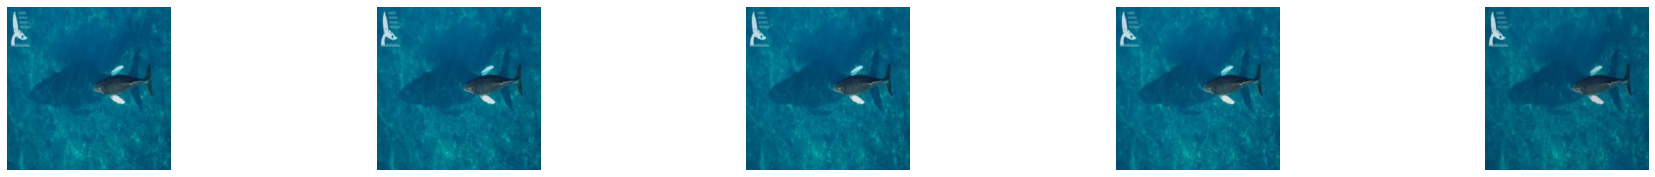

In [37]:
pipe = frame_seq_pipe(path=data_dir, batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()

# for i in range(n_iter):
pipe_out = pipe.run()
sequences_out = np.array(pipe_out[0][0])
print(f"Iteration {i} shape: {sequences_out.shape}")
show_sequence(sequences_out)